In [2]:
import os
import io
from imgsize import get_size
import json
from tqdm import tqdm

from glob import glob
import matplotlib.pyplot as plt
import cv2

##### yolo data format을 위한 이미지 정보를 json파일에 저장

In [3]:

def convert_yolo_format(json_file, imgdir) :
    with open(json_file, 'r') as f :
        json_info = json.load(f)
    
    yolo_json_info = []

    for info in tqdm(json_info) :
        imgfile = os.path.join(imgdir, info['name'])

        with io.open(imgfile, 'rb') as fobj :
            width, height = get_size(fobj)

        info['imgsize'] = [height, width]

        
        label_info = info['labels'] if 'labels' in info.keys() else []

        for idx in range(len(label_info)) :
            # try :
            label = label_info[idx]['category']
            coord = label_info[idx]['box2d']
            # except :
            #     print(label_info[idx])
            #     raise
            xmin, xmax = coord['x1'], coord['x2']
            ymin, ymax = coord['y1'], coord['y2']

            w = xmax - xmin
            h = ymax - ymin

            x_center = xmin + w / 2
            y_center = ymin + h / 2

            w /= width # normalize 0-1
            h /= height

            x_center /= width
            y_center /= height



            info['labels'][idx]['box2d'] = { 'x' : float(x_center),
                                             'y' : float(y_center),
                                             'w' : float(w),
                                             'h' : float(h)
                                                }

        yolo_json_info.append(info)

    return yolo_json_info

def save_json_info(json_info, savename) :
    with open(savename, 'w') as f :
        json.dump(json_info, f)

In [25]:
json_file = 'data/label/det_val.json'
imgdir = 'data/images/val'

val_yolo_json_info = convert_yolo_format(json_file, imgdir)

100%|██████████| 10000/10000 [00:00<00:00, 27625.40it/s]


In [29]:
save_json_info(val_yolo_json_info, 'data/label/yolo_det_val.json')

In [30]:
json_file = 'data/label/det_train.json'
imgdir = 'data/images/train'

train_yolo_json_info = convert_yolo_format(json_file, imgdir)

100%|██████████| 69863/69863 [00:03<00:00, 19834.50it/s]


In [31]:
save_json_info(train_yolo_json_info, 'data/label/yolo_det_train.json')

#### Image Resize

In [4]:

val_imgfiles = glob('data/images/val/*.jpg')

with open('data/label/yolo_det_val.json', 'r') as f :
    val_json = json.load(f)


In [5]:
import albumentations as A

transform = A.Compose([
    A.geometric.resize.SmallestMaxSize(max_size = 446),
    A.RandomCrop(width = 446, height = 446),
], bbox_params = A.BboxParams(format = 'yolo', label_fields = ['label'], min_visibility = 0.1))



In [6]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    img_h, img_w = img.shape[:2]

    x, y, w, h = bbox
    x_min, x_max, y_min, y_max = x - w, x + w, y - w, y + w
    x_min = int(img_w * x_min)
    x_max = int(img_w * x_max)
    y_min = int(img_h * y_min)
    y_max = int(img_h * y_max)



   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [12]:
idx = 0
img = plt.imread(val_imgfiles[idx])
bboxes, labels = zip(*[([l['box2d']['x'], l['box2d']['y'], l['box2d']['w'], l['box2d']['h']], l['category']) \
            for l in val_json[idx]['labels']])



In [15]:
446 // 7

63

In [13]:
transformed = transform(image = img, bboxes = bboxes, label = labels)

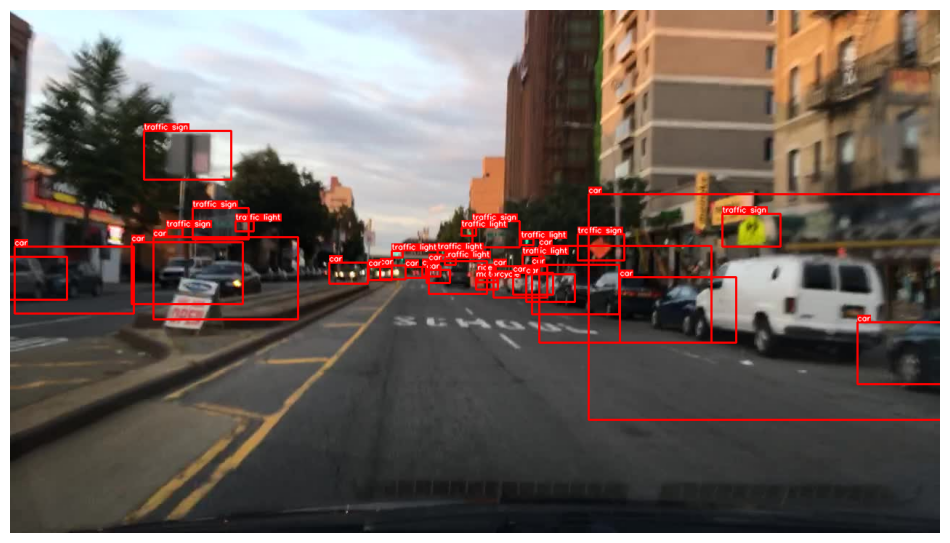

In [14]:
# visualize(transformed['image'], transformed['bboxes'], transformed['label'])
visualize(img, bboxes, labels)